# EDA for GNSS Positioning Reliability Prediction

This notebook provides a comprehensive exploratory data analysis (EDA) for the GNSS Positioning Reliability Prediction challenge. The analysis covers class imbalance, missing values, feature correlations, signal quality, geometry, and time series behavior using the provided Parquet dataset.

In [11]:
# Section 1: Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import os

data_path = 'data/processed/all_data_compressed.parquet'
if os.path.exists(data_path):
    df = pd.read_parquet(data_path)
    print(f"Dataset shape: {df.shape}")
    display(df.head())
else:
    print(f"File not found: {data_path}")
    df = None

# Display info if dataframe is loaded
if df is not None:
    df.info()

Dataset shape: (9821020, 23)


,timestamp,fixType,gnssFixOk,numSV,hAcc,vAcc,tAcc,sAcc,pDOP,hDOP,...,nDOP,eDOP,numSatsTracked,cnoMean,cnoStd,cnoMin,cnoMax,horizontalPositionLabel,verticalPositionLabel,overallPositionLabel
0,2025-08-01 11:23:56.435470,3,1,31,1.235,1.248,0.024,0.075,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0
1,2025-08-01 11:23:56.462573,3,1,31,1.235,1.248,0.024,0.075,NaN,NaN,...,NaN,NaN,30,35.900002,10.2,17.0,53.0,0,0,0
2,2025-08-01 11:23:56.467906,3,1,31,1.235,1.248,0.024,0.075,0.88,0.5,...,0.39,0.31,30,35.900002,10.2,17.0,53.0,0,0,0
3,2025-08-01 11:23:56.948525,3,1,30,1.237,1.249,0.024,0.096,0.88,0.5,...,0.39,0.31,30,35.900002,10.2,17.0,53.0,0,0,0
4,2025-08-01 11:23:56.976757,3,1,30,1.237,1.249,0.024,0.096,0.88,0.5,...,0.39,0.31,29,36.000000,10.4,17.0,53.0,0,0,0


<class 'pandas.DataFrame'>
RangeIndex: 9821020 entries, 0 to 9821019
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   timestamp                datetime64[us]
 1   fixType                  int8          
 2   gnssFixOk                int8          
 3   numSV                    int8          
 4   hAcc                     float32       
 5   vAcc                     float32       
 6   tAcc                     float32       
 7   sAcc                     float32       
 8   pDOP                     float64       
 9   hDOP                     float32       
 10  vDOP                     float32       
 11  tDOP                     float32       
 12  gDOP                     float32       
 13  nDOP                     float32       
 14  eDOP                     float32       
 15  numSatsTracked           int64         
 16  cnoMean                  float32       
 17  cnoStd                   float32      

In [10]:
# Change working directory to project root if needed
import os
os.chdir("..")
print("Changed working directory:", os.getcwd())

Changed working directory: c:\Users\HOME\Desktop\gnss_challenge


In [9]:
import os
print("Current working directory:", os.getcwd())
# If needed, uncomment and set the correct path:
# os.chdir("C:/Users/HOME/Desktop/gnss_challenge")
# print("Changed working directory:", os.getcwd())

Current working directory: c:\Users\HOME\Desktop\gnss_challenge\notebooks


## 2. Target Distribution Analysis (Class Imbalance)

Let's analyze the distribution of the target variable `overallPositionLabel` (0 = Reliable, 1 = Unreliable) to check for class imbalance.

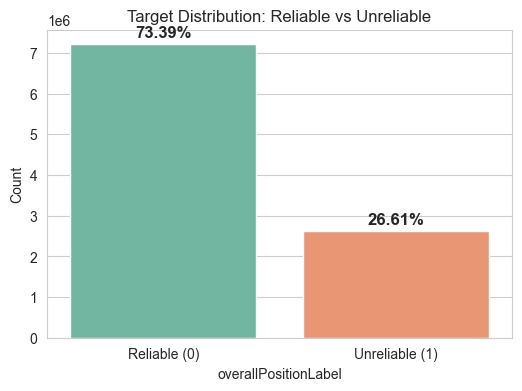

Class distribution (%):
overallPositionLabel
0    73.39
1    26.61
Name: count, dtype: float64


In [28]:
# Calculate class distribution
class_counts = df['overallPositionLabel'].value_counts().sort_index()
class_percent = class_counts / class_counts.sum() * 100

plt.figure(figsize=(6,4))
ax = sns.countplot(
    x='overallPositionLabel',
    data=df,
    hue='overallPositionLabel',
    palette='Set2',
    legend=False,
    order=[0, 1]
)

for i, count in enumerate(class_counts):
    percent = class_percent.iloc[i]
    ax.text(i, count + 0.01*df.shape[0], f'{percent:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Reliable (0)', 'Unreliable (1)'])
ax.set_title('Target Distribution: Reliable vs Unreliable')
plt.ylabel('Count')
plt.xlabel('overallPositionLabel')
plt.savefig('figures/eda_target_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

print('Class distribution (%):')
print(class_percent.round(2))

## 3. Missing Values & Data Integrity

Let's analyze missing values, especially for DOP columns (`PDOP`, `hDOP`) and signal columns (`cnoMean`). In GNSS, missing DOP often means the receiver couldn't calculate a solution.

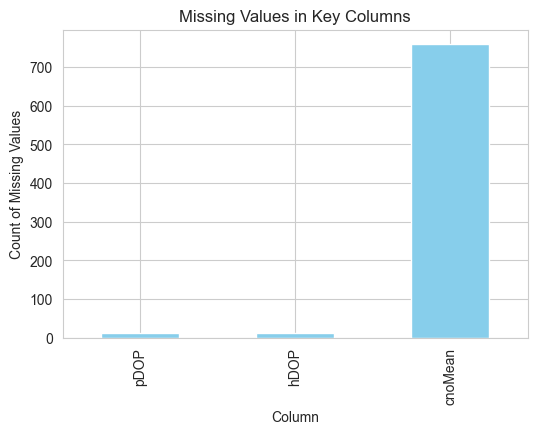

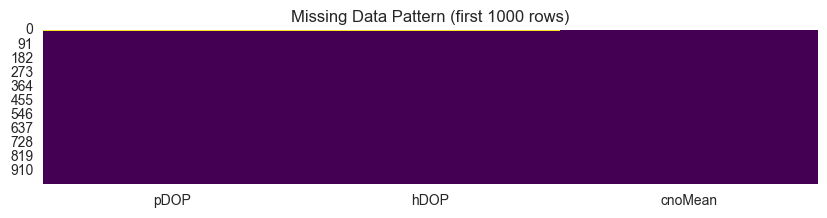

Missing values (%):
pDOP       0.00
hDOP       0.00
cnoMean    0.01
dtype: float64


In [29]:
# Check missing values for key columns
cols_to_check = ['pDOP', 'hDOP', 'cnoMean']
missing_counts = df[cols_to_check].isnull().sum()
missing_percent = df[cols_to_check].isnull().mean() * 100

# Bar plot of missing values
plt.figure(figsize=(6,4))
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Missing Values in Key Columns')
plt.ylabel('Count of Missing Values')
plt.xlabel('Column')
plt.savefig('figures/eda_missing_values_bar.png', bbox_inches='tight', dpi=150)
plt.show()

# Heatmap of missing values (first 1000 rows for visibility)
plt.figure(figsize=(10,2))
sns.heatmap(df[cols_to_check].isnull().head(1000), cbar=False, cmap='viridis')
plt.title('Missing Data Pattern (first 1000 rows)')
plt.savefig('figures/eda_missing_values_heatmap.png', bbox_inches='tight', dpi=150)
plt.show()

print('Missing values (%):')
print(missing_percent.round(2))

In [ ]:
print(df.columns.tolist())

['timestamp', 'fixType', 'gnssFixOk', 'numSV', 'hAcc', 'vAcc', 'tAcc', 'sAcc', 'pDOP', 'hDOP', 'vDOP', 'tDOP', 'gDOP', 'nDOP', 'eDOP', 'numSatsTracked', 'cnoMean', 'cnoStd', 'cnoMin', 'cnoMax', 'horizontalPositionLabel', 'verticalPositionLabel', 'overallPositionLabel']


## 4. Correlation Analysis

Let's compute the correlation matrix for key numerical features and visualize it to understand relationships with the target variable.

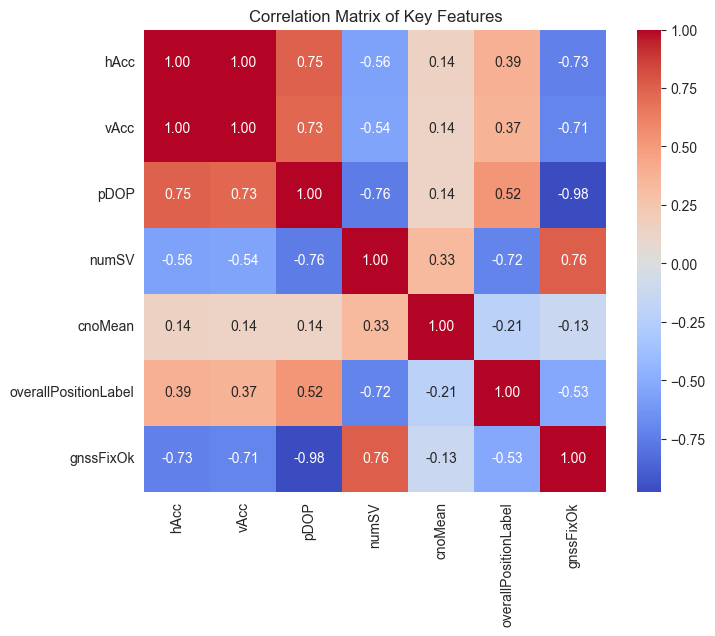

Correlation with target:
overallPositionLabel    1.000000
pDOP                    0.524011
hAcc                    0.385291
vAcc                    0.374176
cnoMean                -0.213128
gnssFixOk              -0.527521
numSV                  -0.718183
Name: overallPositionLabel, dtype: float64


In [30]:
# Correlation matrix for selected features
corr_features = ['hAcc', 'vAcc', 'pDOP', 'numSV', 'cnoMean', 'overallPositionLabel', 'gnssFixOk']
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Key Features')
plt.savefig('figures/eda_corr_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

print('Correlation with target:')
print(corr_matrix['overallPositionLabel'].sort_values(ascending=False))

## 5. Feature Analysis - Signal Quality (C/NO)

Let's compare the distribution of `cnoMean` (signal strength) for Reliable vs Unreliable samples. Lower signal strength is expected to correlate with Unreliable labels.

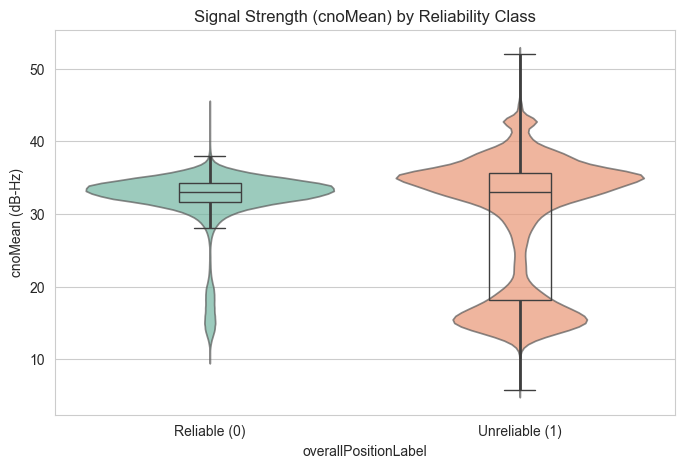

In [31]:
# Boxplot and violin plot for cnoMean by class
plt.figure(figsize=(8,5))
sns.violinplot(x='overallPositionLabel', y='cnoMean', data=df, hue='overallPositionLabel', palette='Set2', alpha=0.7, legend=False, inner=None)
sns.boxplot(x='overallPositionLabel', y='cnoMean', data=df, width=0.2, showcaps=True, boxprops={'facecolor':'None'}, showfliers=False, whiskerprops={'linewidth':2})
plt.xticks([0,1],["Reliable (0)","Unreliable (1)"])
plt.title('Signal Strength (cnoMean) by Reliability Class')
plt.ylabel('cnoMean (dB-Hz)')
plt.xlabel('overallPositionLabel')
plt.savefig('figures/eda_cnoMean_by_class.png', bbox_inches='tight', dpi=150)
plt.show()

## 6. Feature Analysis - Geometry (PDOP vs Accuracy)

Let's visualize the relationship between PDOP (geometry) and hAcc (horizontal accuracy), colored by reliability class.

c:\Users\HOME\Desktop\gnss_challenge\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


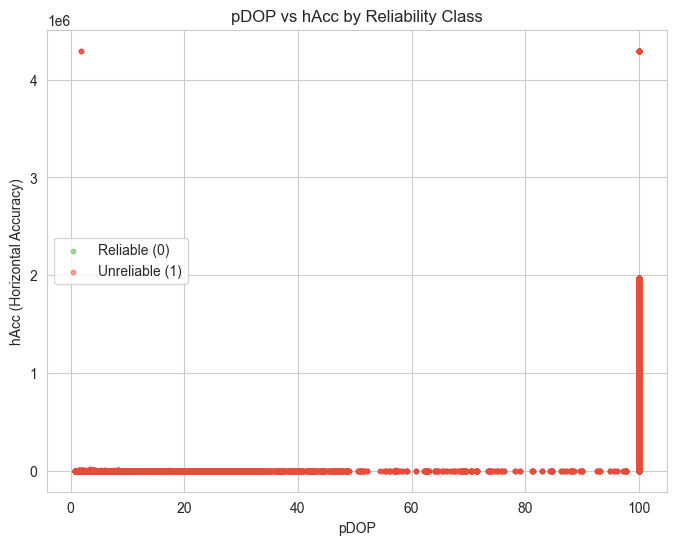

In [ ]:
# Scatter plot: pDOP vs hAcc, colored by reliability
plt.figure(figsize=(8,6))
colors = ['#4CAF50', '#E74C3C']
for label, color in zip([0,1], colors):
    subset = df[df['overallPositionLabel'] == label]
    plt.scatter(subset['pDOP'], subset['hAcc'], label=f'Class {label}', alpha=0.5, s=10, c=color)
plt.xlabel('pDOP')
plt.ylabel('hAcc (Horizontal Accuracy)')
plt.title('pDOP vs hAcc by Reliability Class')
plt.legend(['Reliable (0)', 'Unreliable (1)'])
plt.savefig('figures/eda_pDOP_vs_hAcc.png', bbox_inches='tight', dpi=150)
plt.show()

## 7. Time Series Visualization

Let's plot horizontal accuracy (hAcc) over time for a sample of 1000 rows, highlighting periods with unreliable positioning.

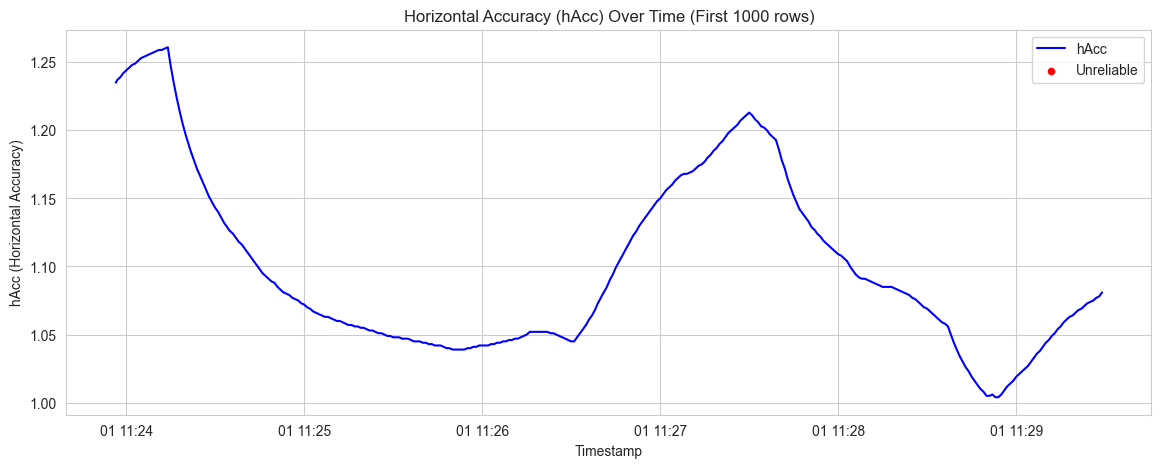

In [33]:
# Time series plot: hAcc over timestamp, highlight unreliable
sample = df.head(1000)
plt.figure(figsize=(14,5))
plt.plot(sample['timestamp'], sample['hAcc'], label='hAcc', color='blue')

# Highlight unreliable regions
unreliable = sample[sample['overallPositionLabel'] == 1]
plt.scatter(unreliable['timestamp'], unreliable['hAcc'], color='red', label='Unreliable', s=20, zorder=3)

plt.title('Horizontal Accuracy (hAcc) Over Time (First 1000 rows)')
plt.xlabel('Timestamp')
plt.ylabel('hAcc (Horizontal Accuracy)')
plt.legend()
plt.savefig('figures/eda_hAcc_time_series.png', bbox_inches='tight', dpi=150)
plt.show()